<img src="https://cienciasgeodesicas.ufpr.br/wp-content/uploads/2021/03/cropped-folder-site3.png" alt="Drawing"/>

**Universidade Federal do Paraná**

Programa de Pós-Graduação em Ciências Geodésicas (PPGCG)

---

*PhD Thesis: TOPONYMS IN TOPOGRAPHIC MAPPING: AN INTEGRATED APPROACH USING OPEN AND COLLABORATIVE GEOSPATIAL DATA*

Authors:
 - Darlan Miranda Nunes | [ORCID- 0000-0003-3557-5341](https://orcid.org/0000-0001-5566-7919)
 - Silvana Philippi Camboim | [ORCID- 0000-0003-3557-5341](https://orcid.org/0000-0003-3557-5341)

---

***Article Title: Quantitative Analysis of Collaborative Toponyms in OpenStreetMap: Investigating the Connections with Intrinsic Quality Parameters***

 - DIAGNÓSTICO QUANTITATIVO DOS TOPÔNIMOS COLABORATIVOS NO
OSM E A RELAÇÃO COM OS PARÂMETROS INTRÍNSECOS DE QUALIDADE

**Aims**

- To conduct a quantitative assessment of elements within OpenStreetMap (OSM) that have the 'name' attribute filled for potential categories of the Brazilian Authoritative Topographic Map; and

- To investigate the most significant intrinsic quality parameters that contribute to the reliability of toponyms in OSM.


<img src="../images/flowchart_article01_v2.png" width="600">

### Install the necessary libraries to the analysis

In [ ]:
# In case of using colab, install these necessary libraries
%pip install geopandas matplotlib pysal seaborn mapclassify mgwr -q

### Import the libraries

In [1]:
# Import library and some pre-installed modules
import os
import numpy as np
import json
import folium
import pandas as pd
import geopandas as gpd
import mapclassify
import matplotlib.colors
import seaborn as sns
#import branca
import pysal
import mgwr # to apply the Geographically Weighted Regression (GWR)
import branca.colormap as cm
from branca.colormap import linear
from matplotlib import pyplot as plt
from branca.element import Figure, Element
from ipywidgets import widgets, Layout, Button, interact, Dropdown, SelectMultiple, HBox, VBox
from IPython.display import display, clear_output
from folium import plugins, Map, Choropleth, Element, Figure
from folium.features import GeoJson, GeoJsonTooltip
import statsmodels.api as sm
from pysal.explore import esda
from pysal.lib import weights
from shapely.geometry import MultiPolygon
from jinja2 import Template
from tqdm.notebook import tqdm

/Users/darlanmnunes/miniconda3/envs/env-DScPythonGeo/lib/python3.10/site-packages/spaghetti/network.py:42: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


### Connect to Google Drive

In [ ]:
# In case of using colab, conect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

### Analysis of Collaborative Toponyms in OpenStreetMap

In [2]:
# @title Import the grid with the aggregated data extracted from OSM via the OHSOME API
grid_osm = None

# Function for selecting and loading the GeoJSON file
def select_file(change):
    global grid_osm
    selected_file = change['new']
    
    if selected_file != "Select the GeoJSON file:":
        file_path = os.path.join('../data/', selected_file)
        try:
            with open(file_path, 'r') as file:
                grid_osm = json.load(file)
            print("File selected with success:", selected_file)
            print("File path:", file_path)
        except FileNotFoundError:
            print("File not found:", selected_file)

# Listing available GeoJSON files
file_list = [f for f in os.listdir('../data/') if f.endswith('.geojson')]
options = ["Select the GeoJSON file:"] + file_list

# Dropdown to select the GeoJSON file
dropdown = widgets.Dropdown(options=options)
dropdown.observe(select_file, names='value')

# Display the dropdown
display(dropdown)

Dropdown(options=('Select the GeoJSON file:', 'grade_id77_passare_results.geojson', 'grade_id25_aguaverde_resu…

File selected with success: grade_id77_passare_results.geojson
File path: ../data/grade_id77_passare_results.geojson


In [3]:
# Preview grid cells
grid_osm

{'type': 'FeatureCollection',
 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::4674'}},
 'features': [{'type': 'Feature',
   'properties': {'id': '200ME67074N108676',
    'POP10': 3,
    'leisure_total_count': 0.0,
    'leisure_name_count': 0.0,
    'leisure_name_ratio': 0,
    'building_total_count': 7.0,
    'building_name_count': 0.0,
    'building_name_ratio': 0.0,
    'amenity_total_count': 0.0,
    'amenity_name_count': 0.0,
    'amenity_name_ratio': 0,
    'leisure_total_contributions': 0.0,
    'leisure_name_contributions': 0.0,
    'building_total_contributions': 39.0,
    'building_name_contributions': 0.0,
    'amenity_total_contributions': 0.0,
    'amenity_name_contributions': 0.0,
    'leisure_latest5_name_contributions': 0.0,
    'building_latest5_name_contributions': 0.0,
    'amenity_latest5_name_contributions': 0.0,
    'leisure_name_tagChange_contributions': 0.0,
    'building_name_tagChange_contributions': 0.0,
    'amenity_name_tagChange_contr

In [4]:
#@title Convert GeoJSON Data to GeoDataFrame
gdf_osm = gpd.GeoDataFrame.from_features(grid_osm['features'])

In [5]:
# Check the first five records of GeoDataFrame
gdf_osm.head()

,geometry,id,POP10,leisure_total_count,leisure_name_count,leisure_name_ratio,building_total_count,building_name_count,building_name_ratio,amenity_total_count,...,amenity_name_contributions,leisure_latest5_name_contributions,building_latest5_name_contributions,amenity_latest5_name_contributions,leisure_name_tagChange_contributions,building_name_tagChange_contributions,amenity_name_tagChange_contributions,leisure_users_count_name,building_users_count_name,amenity_users_count_name
0,"MULTIPOLYGON (((-38.54451 -3.82662, -38.54461 ...",200ME67074N108676,3,0.0,0.0,0.0,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"MULTIPOLYGON (((-38.54271 -3.82652, -38.54281 ...",200ME67076N108676,166,2.0,0.0,0.0,29.0,0.0,0.0,3.0,...,14.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,5.0
2,"MULTIPOLYGON (((-38.54090 -3.82643, -38.54100 ...",200ME67078N108676,562,0.0,0.0,0.0,33.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"MULTIPOLYGON (((-38.54461 -3.82483, -38.54471 ...",200ME67074N108678,223,0.0,0.0,0.0,78.0,0.0,0.0,1.0,...,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,"MULTIPOLYGON (((-38.54281 -3.82473, -38.54291 ...",200ME67076N108678,62,0.0,0.0,0.0,49.0,0.0,0.0,2.0,...,3.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,2.0,3.0


In [6]:
# Check the number os grid cell with information retrived of OSM
len(gdf_osm)

220

#### Histogram Analysis

Dropdown(description='Column:', index=8, options=('geometry', 'id', 'POP10', 'leisure_total_count', 'leisure_n…

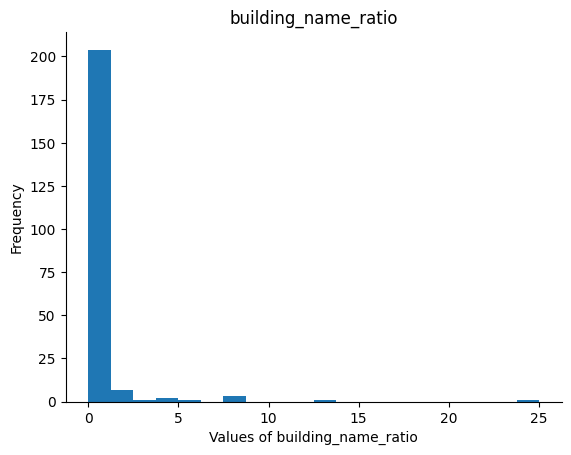

In [7]:
# @title Preliminary analysis with histograms

import ipywidgets as widgets
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

# Creating a selection widget for columns
dropdown = widgets.Dropdown(
    options = gdf_osm.columns, # list of DataFrame columns
    value = 'building_name_ratio', # default value
    description = 'Column:',
    disabled = False,
)

# Function to plot the histogram
def plot_histogram(column):
    clear_output(wait=True) # clears the previous output
    display(dropdown)  # Show the widget again after clearing the output

    # Plots the histogram for the specified column
    gdf_osm[column].plot(kind='hist', bins=20, title=column)

    # Styling the graphic
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.xlabel(f'Values of {column}')  # add the  X axis title
    plt.show()

# Linking the plot function to the dropdown value change event
dropdown.observe(lambda change: plot_histogram(change.new), 'value')

# Show the widget
display(dropdown)

# Initial plot
plot_histogram(dropdown.value)

#### Choropleth maps

In [ ]:
# @title Choropleth maps

from shapely.geometry import MultiPolygon
import warnings

# FutureWarning ignore
warnings.simplefilter(action='ignore', category=FutureWarning)

# Function to calculate the centroid of all grid cells in the GeoDataFrame
def calculate_centroid_of_union(gdf):
    union_poly = gdf.geometry.unary_union
    if isinstance(union_poly, MultiPolygon):
        union_poly = MultiPolygon(union_poly).convex_hull
    return [union_poly.centroid.y, union_poly.centroid.x]

# Function to generate the choropleth map using the quantile metohod and folium
def add_choropleth(map_obj, column, method, palette):
    unique_values = len(gdf_osm[column].unique())
    k = min(4, unique_values)

    if method == 'Quantiles':
        classifier = mapclassify.Quantiles(gdf_osm[column], k=k)
    elif method == 'EqualInterval':
        classifier = mapclassify.EqualInterval(gdf_osm[column], k=k)
    elif method == 'NaturalBreaks':
        classifier = mapclassify.NaturalBreaks(gdf_osm[column], k=k)
    else:
        raise ValueError("Classification method not supported")

    colors = [matplotlib.colors.to_hex(matplotlib.colormaps.get_cmap(palette)(i / k)) for i in range(k)]

    gdf_osm['class'] = classifier.yb

    choropleth = folium.Choropleth(
          geo_data=gdf_osm.to_json(),
          data=gdf_osm,
          columns=['id', 'class'],
          key_on='feature.properties.id',
          fill_color=palette,
          fill_opacity=0.5,
          line_opacity=0.4,
          show=False
      ).add_to(map_obj)

    # Add tooltips
    folium.GeoJsonTooltip(fields=['id', column]).add_to(choropleth.geojson)

    return classifier.bins, k  # Returns the intervals to use in the legend

# Function to creating HTML Legend
def create_legend_html(bins, colors, legend_labels, method, column):
    num_intervals = len(bins)
    legend_title = f"{method} classification of {column}"
    legend_html = f'''
    <div style="position: fixed;
    bottom: 50px; left: 50px; width: 200px; height: auto;
    border:2px solid grey; z-index:9999; font-size:14px; padding: 5px; background: rgba(255, 255, 255, 0.8);">
    &nbsp; {legend_title} <br>
    '''
    num_intervals = len(bins)
    for i in range(num_intervals):
        color = matplotlib.colors.rgb2hex(colors[i])
        if i == 0:
            interval_text = f"≤ {bins[i]:.2f}"
        elif i == num_intervals - 1:
            interval_text = f"> {bins[i - 1]:.2f}"
        else:
            interval_text = f"{bins[i - 1]:.2f} - {bins[i]:.2f}"

        legend_html += f'''
        &nbsp; <i style="background: {color}; width: 20px; height: 20px; float: left; margin-right: 4px;"></i>
        <span>{legend_labels[i]}: {interval_text}</span><br clear="all">
        '''
    legend_html += '</div>'
    return legend_html

def get_legend_labels(method, k):
    if method == 'Quantiles':
        return [f'Q{i+1}' for i in range(k)]
    elif method == 'EqualInterval':
        return [f'Interval {i+1}' for i in range(k)]
    elif method == 'NaturalBreaks':
        return [f'Break {i+1}' for i in range(k)]
    else:
        raise ValueError("Classification method not supported")

# Function to update the map with the selected column
def update_map(column, method, palette):
    fig = Figure(width=1080, height=650)
    centroid_coords = calculate_centroid_of_union(gdf_osm)
    
    m = folium.Map(location=centroid_coords, zoom_start=14, control_scale=True)
    m.add_to(fig)

    intervals, k = add_choropleth(m, column, method, palette)
    colors = [matplotlib.colors.to_hex(matplotlib.colormaps.get_cmap(palette)(i / k)) for i in range(k)]
    legend_labels = get_legend_labels(method, k)

    legend_html = create_legend_html(intervals, colors, legend_labels, method, column)
    m.get_root().html.add_child(Element(legend_html))

    title_html = f'''
    <div style="position: fixed;
    top: 10px; left: 50%; transform: translate(-50%, 0); width: auto;
    border:2px solid grey; z-index:9999; font-size:16px; font-weight: bold;
    background: rgba(255, 255, 255, 0.8); text-align: center; padding: 5px;">
    Choropleth map of {column}</div>
    '''
    m.get_root().html.add_child(folium.Element(title_html))

    display(fig)

# Dropdown widget for column selection
column_selector = widgets.Dropdown(
    options=gdf_osm.columns,
    value='building_name_ratio', # default value
    description='Column:',
    layout=Layout(width='30%', height='30px')
)

method_selector = widgets.Dropdown(
    options=['Quantiles', 'EqualInterval', 'NaturalBreaks'],
    value='Quantiles',  # default
    description='Method:',
    layout=Layout(width='30%', height='30px')
)

palette_selector = widgets.Dropdown(
    options=plt.colormaps(),
    value='YlGn',  # default value
    description='Palette:',
    layout=Layout(width='30%', height='30px')
)

# Action function when the button is clicked
def on_button_clicked(b):
    update_map(column_selector.value, method_selector.value, palette_selector.value)

def clear_outputs(b):
    clear_output()
    display_widgets()

def display_widgets():
    button = Button(description="Generate map")
    clear_button = Button(description="Clear Output")

    button.on_click(on_button_clicked)
    clear_button.on_click(clear_outputs)

    display(column_selector, method_selector, palette_selector, button, clear_button)

# Display the Widgets and the Button
display_widgets()

Dropdown(description='Column:', index=8, layout=Layout(height='30px', width='30%'), options=('geometry', 'id',…

Dropdown(description='Method:', layout=Layout(height='30px', width='30%'), options=('Quantiles', 'EqualInterva…

Dropdown(description='Palette:', index=33, layout=Layout(height='30px', width='30%'), options=('magma', 'infer…

Button(description='Generate map', style=ButtonStyle())

Button(description='Clear Output', style=ButtonStyle())

In [ ]:
# Checking the ne column used to calculate the quantiles
print(gdf_osm['building_name_ratio'].describe())

#### Spatial Autocorrelation Analysis

##### Global Moran's Index

- The bellow ceel code allows the user to select multiple variables from a GeoDataFrame and then analyze each one for spatial autocorrelation using Moran's I. The results, including the value of Moran's I and its p-value, are printed and visualized in a scatterplot for each selected variable. The selection widget's width is adjusted for better display.


- Statistical test

  - Null hypothesis represents the spatial independence of the data (Spatial distribution of the variable in question is random )
  - Confidence margin of 95% (p value < .05)

In [ ]:
import warnings
from pysal.lib import weights
from esda.moran import Moran
from splot.esda import plot_moran

# FutureWarning ignore
warnings.simplefilter(action='ignore', category=FutureWarning)

# Function to perform Moran's I analysis
def analyze_morans_i(selected_vars):
    w = weights.Queen.from_dataframe(gdf_osm, use_index=True)
    w.transform = 'r'

    for var in selected_vars:
        moran = Moran(gdf_osm[var], w)
        print(f"Moran's Index for {var}: {moran.I:.4f}, p-value: {moran.p_sim}")

        # Plot the Moran scatterplot
        plot_moran(moran, zstandard=True, figsize=(10, 4))
        plt.show()

# Button to perform the analysis
analyze_button = widgets.Button(description="Analyze Moran's I")

# Button to clear the output
clear_output_button = widgets.Button(description="Clear Output")

# Create the selection widget with adjusted layout
select_variables = widgets.SelectMultiple(
    options=gdf_osm.columns,
    value=['leisure_name_ratio'],  # default value
    description='Variables',
    disabled=False,
    layout={'width': '50%', 'height': '200px'}
)

# Display the widgets
display(select_variables, analyze_button, clear_output_button)

# Function to handle button click event
def on_analyze_button_clicked(b):
    analyze_morans_i(select_variables.value)

def on_clear_output_button_clicked(b):
    clear_output()

# Bind the button click events to their respective functions
analyze_button.on_click(on_analyze_button_clicked)
clear_output_button.on_click(on_clear_output_button_clicked)

##### Hot Spot analysis using the Getis-Ord Gi statistic

In [ ]:
gdf_osm = gdf_osm.set_crs("EPSG:4674")

# Function to calculate the centroid of the union of grid cells
def calculate_centroid_of_union(gdf):
    union_poly = gdf.geometry.unary_union
    if isinstance(union_poly, MultiPolygon):
        union_poly = MultiPolygon(union_poly).convex_hull
    return [union_poly.centroid.y, union_poly.centroid.x]

# Function to color points based on Z-score
def color_producer(val):
    if val > 2.0:
        return 'darkred'  # Significant hot-spot
    elif 1.0 < val <= 2.0:
        return 'red'  # Moderate hot-spot
    elif -1.0 <= val <= 1.0:
        return 'green'  # Non-significant
    elif -2.0 <= val < -1.0:
        return 'blue'  # Moderate Cold-spot
    else:
        return 'darkblue'  # Significant Cold-spot

# Function to calculate Getis-Ord Gi*
def calculate_getis_ord_gi(gdf, var_name):
    w = weights.distance.KNN.from_dataframe(gdf, k=8)  # Adjust 'k' as necessary
    w.transform = 'B'
    gi = esda.G_Local(gdf[var_name], w, star=True)  # 'star' parameter considers all neighbors
    gdf[f"Gi_Z_{var_name}"] = gi.Zs  # Adds Getis-Ord Gi* Z-score to the GeoDataFrame
    return gdf

def create_title_html(selected_var):
    title_html = f'''
    <div style="position: fixed;
    top: 10px; left: 50%; transform: translate(-50%, 0); width: auto;
    border:2px solid grey; z-index:9999; font-size:16px; font-weight: bold;
    background: rgba(255, 255, 255, 0.8); text-align: center; padding: 5px;">
    Getis-Ord Gi* Analysis for {selected_var}</div>
    '''
    return title_html

def create_legend_html():
    legend_html = '''
    <div style="position: fixed;
    bottom: 50px; left: 50px; width: 270px; height: auto;
    border:2px solid grey; z-index:9999; font-size:14px;
    background: rgba(255, 255, 255, 0.8);  /* White with 80% opacity */
    ">&nbsp; <b>Legend</b> <br>
    &nbsp; Significant hot-spot (Z > 2.0) &nbsp; <i style="background:darkred;width:10px;height:10px;display:inline-block;"></i><br>
    &nbsp; Moderate hot-spot (1.0 < Z ≤ 2.0) &nbsp; <i style="background:red;width:10px;height:10px;display:inline-block;"></i><br>
    &nbsp; Non-significant (-1.0 ≤ Z ≤ 1.0) &nbsp; <i style="background:green;width:10px;height:10px;display:inline-block;"></i><br>
    &nbsp; Moderate cold-spot (-2.0 ≤ Z < -1.0) &nbsp; <i style="background:blue;width:10px;height:10px;display:inline-block;"></i><br>
    &nbsp; Significant cold-spot (Z < -2.0) &nbsp; <i style="background:darkblue;width:10px;height:10px;display:inline-block;"></i>
    </div>
    '''
    return legend_html

# Function to perform Getis-Ord Gi* analysis and create the map
def analyze_getis_ord_gi(selected_var):
    print("Processing, please wait...")
    gdf_with_gi = calculate_getis_ord_gi(gdf_osm, selected_var)
    centroid_coords = calculate_centroid_of_union(gdf_with_gi)
    fig = Figure(width=1080, height=650)

    m = folium.Map(location=centroid_coords, zoom_start=14, control_scale=True)
    m.add_to(fig)

    # Adding CircleMarkers for each cell's centroid
    for _, row in gdf_with_gi.iterrows():
        centroid = row.geometry.centroid if isinstance(row.geometry, MultiPolygon) else row.geometry
        folium.CircleMarker(
            location=[centroid.y, centroid.x],
            radius=3,
            color=color_producer(row[f"Gi_Z_{selected_var}"]),
            fill=True,
            fill_opacity=1
        ).add_to(m)

    # Function to apply style to cells
    def style_function(feature):
        value = feature['properties'][f"Gi_Z_{selected_var}"]
        return {
            'fillColor': color_producer(value),
            'color': 'gray',
            'weight': 1,
            'fillOpacity': 0.05,
            'lineOpacity': 0.3
        }

    # Add GeoJson to the map
    folium.GeoJson(
        gdf_with_gi,
        style_function=style_function
    ).add_to(m)

    legend_html = create_legend_html()
    title_html = create_title_html(selected_var)
    m.get_root().html.add_child(folium.Element(legend_html))
    m.get_root().html.add_child(folium.Element(title_html))

    #fig = Figure(width=1080, height=650)
    #fig.add_child(m)

    display(fig)

# Create widgets for user interaction
select_variable_widget = widgets.Select(
    options=gdf_osm.columns,
    description='Variable:',
    disabled=False,
    layout={'width': '30%', 'height': '150px'}
)

analyze_button = widgets.Button(description="Analyze and Show Map")
clear_output_button = widgets.Button(description="Clear Output")

# Layout for displaying widgets
box_layout = VBox([select_variable_widget,
                   HBox([analyze_button, clear_output_button])])
display(box_layout)

def on_analyze_button_clicked(b):
    clear_output(wait=True)
    display(VBox([HBox([analyze_button, clear_output_button]), select_variable_widget]))
    analyze_getis_ord_gi(select_variable_widget.value)

def on_clear_output_button_clicked(b):
    clear_output(wait=True)
    display(VBox([HBox([analyze_button, clear_output_button]), select_variable_widget]))

analyze_button.on_click(on_analyze_button_clicked)
clear_output_button.on_click(on_clear_output_button_clicked)



##### Geographically Weighted ANOVA (GWANOVA)

In [ ]:
from pysal.lib import weights
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import MultiPolygon
from ipywidgets import widgets, VBox, HBox
from IPython.display import display, clear_output

gdf_osm = gdf_osm.set_crs("EPSG:4674")
gdf_osm_projected = gdf_osm.to_crs("EPSG:31983")

# Function to calculate the centroid of a union of grid cells
def calculate_centroid_of_union(gdf):
    union_poly = gdf.geometry.unary_union
    if isinstance(union_poly, MultiPolygon):
        union_poly = MultiPolygon(union_poly).convex_hull
    return [union_poly.centroid.y, union_poly.centroid.x]

# Function to perform Geographically Weighted ANOVA
def perform_gwanova(gdf, selected_y_var, selected_x_vars):
    print("Processing, please wait...")
    y = gdf[selected_y_var].values.reshape((-1, 1))
    X = gdf[selected_x_vars].values

    # Calculating centroids in projected CRS
    u = gdf.geometry.centroid.x.values
    v = gdf.geometry.centroid.y.values
    coords = np.array(list(zip(u, v)))

    # Creating GWANOVA model
    gwr_selector = Sel_BW(coords, y, X)
    bw = gwr_selector.search(bw_min=2)
    gwr_model = GWR(coords, y, X, bw=bw).fit()

    # Storing Local_R2 values
    gdf['Local_R2'] = gwr_model.localR2

    # Displaying results
    plt.scatter(u, v, c=gwr_model.localR2, cmap='Reds')
    plt.colorbar(label='Local R2')
    dependent_vars_str = ', '.join(selected_x_vars)
    plt.title(f'GWANOVA: {selected_y_var} vs. {dependent_vars_str}')
    plt.show()

# Widgets for user interaction
select_y_variable_widget = widgets.Dropdown(
    options=[col for col in gdf_osm.columns if col != 'geometry'],  # Excluding the 'geometry' column
    description='Dependent Variable:',
    disabled=False,
)

select_x_variables_widget = widgets.SelectMultiple(
    options=[col for col in gdf_osm.columns if col != 'geometry'],  # Excluding the 'geometry' column
    description='Independent Variables:',
    disabled=False,
    layout={'width': '40%', 'height': '200px'}
)

analyze_button = widgets.Button(description="Perform GWANOVA")
clear_button = widgets.Button(description="Clear Results")

# Layout for displaying widgets
box_layout = VBox([select_y_variable_widget,
                   select_x_variables_widget,
                   HBox([analyze_button, clear_button])])
display(box_layout)

# Analyze button click function
def on_analyze_button_clicked(b):
    clear_output(wait=True)
    display(box_layout)  # Redisplay the widgets
    selected_y_var = select_y_variable_widget.value
    selected_x_vars = list(select_x_variables_widget.value)
    perform_gwanova(gdf_osm_projected, selected_y_var, selected_x_vars)

# Clear button click function
def on_clear_button_clicked(b):
    clear_output(wait=True)
    display(box_layout)

analyze_button.on_click(on_analyze_button_clicked)
clear_button.on_click(on_clear_button_clicked)

#### Multiple Regression Analysis

In [ ]:
# Convert GeoDataFrame to DataFrame by removing the geometry column
gdf_osm_copy = gdf_osm.copy()
df_osm = gdf_osm_copy.drop(columns=['geometry'])

In [ ]:
# Verify the first five records
df_osm.head()

In [ ]:
# Check the data types
df_osm.dtypes

In [ ]:
# Dynamic selection of the dependent variable and the independent variables
# Dependent variables
dependent_var_widget = Dropdown(options=[col for col in df_osm.columns if col != 'id'],
                                description='Dependent Var:')

# Independent variables
independent_vars_widget = SelectMultiple(
    options=[col for col in df_osm.columns if col != 'id'],
    description='Independent Vars:',
    layout={'width': '90%', 'height': '200px'})

# Global Dictionary to store all regression summaries
regression_summaries = {}

# Global dictionary for storing R² values
r2_values = {}

# Function to run the regression
def run_regression(button):
    global regression_summaries, r2_values
    dependent_var = dependent_var_widget.value
    independent_vars = list(independent_vars_widget.value)
    X = df_osm[independent_vars]
    y = df_osm[dependent_var]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    regression_summary = model.summary().as_text()

    # Print the summary for the current run
    print(regression_summary)

    # Store the summary using the model name as the key
    model_name = f"{dependent_var} ~ {' + '.join(independent_vars)}"
    regression_summaries[model_name] = regression_summary

    # Store R² Adjusted values
    r2_values[model_name] = model.rsquared_adj

# Function to clear the outputs
def clear_outputs(button):
    clear_output()
    display_widgets()

# Function to save all regression results
def save_regression_results(button):
    save_path = '/content/drive/MyDrive/UFPR_PPGCG_DSc/DSc_Dev/02-saidas/02_testes_feicoes_agregadasGrade/agua_verde/v2/regression_summaries.txt'
    if regression_summaries:
        with open(save_path, "w") as file:
            for model, summary in regression_summaries.items():
                file.write(f"Model: {model}\n")
                file.write(f"{summary}\n\n")
        print("All results saved successfully.")
    else:
        print("No results to save.")

# Function to Generate the Bar Chart for Adjusted R² Values
def plot_r2_bar_chart():
    # Convert the dictionary of R² values into a DataFrame for visualization
    df_r2 = pd.DataFrame(list(r2_values.items()), columns=['Model', 'Adjusted R2'])

    # Sort the models by 'Adjusted R2' values for better visualization
    df_r2_sorted = df_r2.sort_values(by='Adjusted R2', ascending=True)

    # Create the bar chart with bars closer together
    fig, ax = plt.subplots(figsize=(10, 8))
    bars = sns.barplot(x='Adjusted R2', y='Model', data=df_r2_sorted, palette='viridis', dodge=False)

    # Add labels and title for the chart
    ax.set_xlabel('Adjusted R²')
    ax.set_ylabel('Model')
    ax.set_title('Adjusted R² Values for Different Regression Models')

    # Add the values on the bars
    for bar in bars.patches:
        ax.text(
            bar.get_width(),  # get the horizontal end point of the bar
            bar.get_y() + bar.get_height() / 2,  # get the y position of the bar
            f'{bar.get_width():.2f}',  # the value we want to add as text
            va='center',  # vertical alignment
            ha='left',  # horizontal alignment
            color='black',  # text color
            fontweight='light'  # font weight
        )

    # Display the chart
    plt.tight_layout()
    plt.show()

# Function to Buttons actions
def button_actions(b):
    if b.description == 'Run Regression':
        run_regression(b)
    elif b.description == 'Clear Outputs':
        clear_outputs(b)
    elif b.description == 'Save Results':
        save_regression_results(b)
    elif b.description == 'Generate R² bar chart':
        plot_r2_bar_chart()

# Create Buttons to run the analysis
run_button = Button(description='Run Regression')
heatmap_button = Button(description='Generate R² bar chart')
save_button = Button(description="Save Results")
clear_button = Button(description="Clear Outputs")

# Assign the button_actions function as the on_click event handler for all buttons
for button in [run_button, heatmap_button, save_button, clear_button]:
    button.on_click(button_actions)

# Organize the widgets
variable_selection_box = VBox([dependent_var_widget, independent_vars_widget])
buttons_box = VBox([run_button, heatmap_button, save_button, clear_button])

# Function to display the widgets
def display_widgets():
    hbox = HBox([variable_selection_box, buttons_box])
    display(hbox)

# Display the Widgets and the Buttons
display_widgets()